In [1]:
import sys
env_path = "/nfs/home/hussain/miniconda3/envs/sfune"
sys.path.append(env_path)

In [2]:
print(sys.executable)
!which python
# !export PATH=~/miniconda3/bin:$PATH

/nfs/home/hussain/miniconda3/envs/sfune/bin/python
/nfs/home/hussain/miniconda3/envs/sfune/bin/python


In [3]:
# Download dataset
#!wget "https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/cloudmaskcompetition/train_true_color.zip" -O train_true_color.zip
# !wget "https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/cloudmaskcompetition/train_mask.zip" -O "train_mask.zip"
# !wget "https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/cloudmaskcompetition/evaluation_true_color.zip" -O "evaluation_true_color.zip" 
# !wget "https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/cloudmaskcompetition/sample.zip" -O "sample.zip" 

In [4]:
import torch
print("torch.__version__: ",torch.__version__)
torch.cuda.is_available()
import os, glob, random, time, gc
from tqdm.notebook import tqdm
from tqdm import tqdm

import tifffile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from torch.utils.data import Dataset

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

torch.__version__:  2.0.1+cu117


## Check Dataset

img_path:  ./data/train_true_color/train_true_color_5.tif
(1000, 1000, 1, 3) uint8 132 255


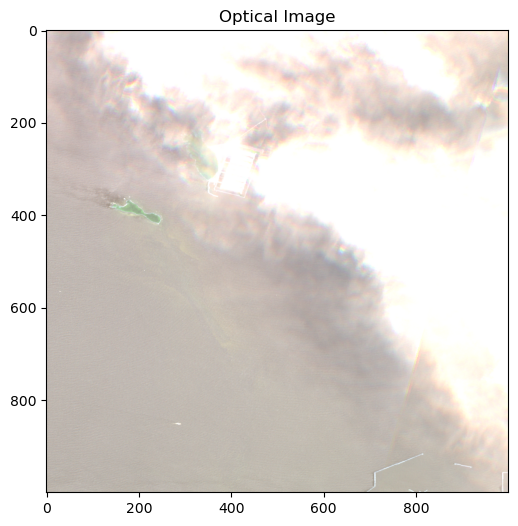

In [5]:
import os
PATH_ID = './data/train_true_color/'
# Check if the directory exists. If not, create it.
if not os.path.exists('input'):
    os.makedirs('input')

imgs = []
plt.figure(figsize=(8, 6))
# for i in [1, 2, 3]:
for i in [5]:
    img_path = PATH_ID + f'train_true_color_{i}.tif'
    print("img_path: ",img_path)
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    img = img.astype(np.float32)
    img = np.clip(img, 400, 2400) / 2400
    imgs.append(img)

imgs = np.stack(imgs, axis=2)
imgs = (imgs * 255).astype(np.uint8)
print(imgs.shape, imgs.dtype, imgs.min(), imgs.max())

plt.imshow(imgs[:,:,0,:])

plt.title('Optical Image')
plt.show()

img_path:  ./data/train_mask/train_mask_808.tif
(1000, 1000, 1) uint8 42 42


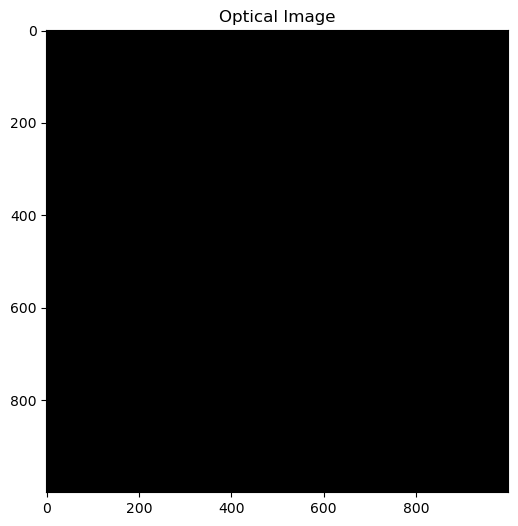

In [6]:
import os
# PATH_ID = './OUTPUT_Predictions/'
PATH_ID = './data/train_mask/'
# Check if the directory exists. If not, create it.
if not os.path.exists('input'):
    os.makedirs('input')

imgs = []
plt.figure(figsize=(8, 6))
# for i in [1, 2, 3]:
for i in [808]:
    # img_path = PATH_ID + f'evaluation_mask_{i}.tif'
    img_path = PATH_ID + f'train_mask_{i}.tif'
    print("img_path: ",img_path)
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    img = img.astype(np.float32)
    img = np.clip(img, 400, 2400) / 2400
    imgs.append(img)

imgs = np.stack(imgs, axis=2)
imgs = (imgs * 255).astype(np.uint8)
print(imgs.shape, imgs.dtype, imgs.min(), imgs.max())

# plt.imshow(imgs[:,:,0,:])
plt.imshow(imgs[:, :, 0], cmap='gray')

plt.title('Optical Image')
plt.show()

## Sample Data

Type: <class 'numpy.ndarray'>
Shape: (1000, 1000)


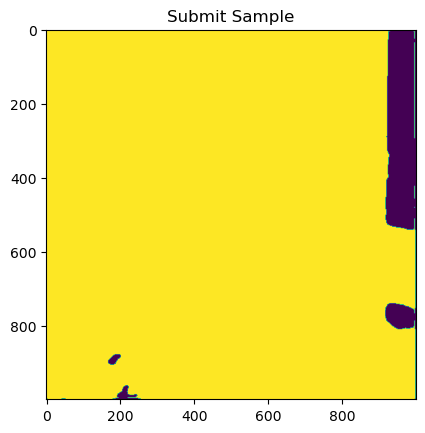

In [7]:
PATH_SAMPLE = './OUTPUT_Predictions/submission/evaluation_mask_915.tif'

img = tifffile.imread(PATH_SAMPLE)
print("Type:", type(img))
print("Shape:", img.shape)

plt.imshow(img)
plt.title('Submit Sample')
plt.show()


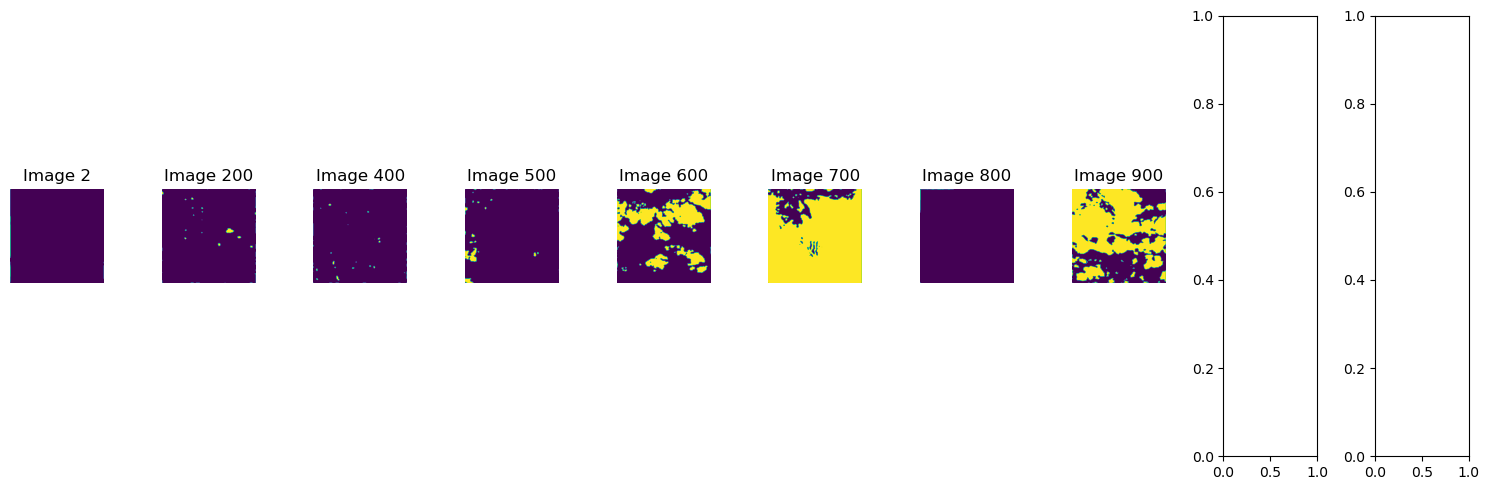

In [9]:
import tifffile
import matplotlib.pyplot as plt

BASE_PATH = './OUTPUT_Predictions/submission/'

fig, axes = plt.subplots(1, 10, figsize=(15, 5))  # Notice I changed NUM_IMAGES to 10 directly here

for idx, i in enumerate([2, 200, 400, 500, 600, 700, 800, 900]):  # Removed 20 since you have 10 axes only
    # Construct the path to the image
    path = BASE_PATH + 'evaluation_mask_' + str(i) + '.tif'
    
    # Read the image
    img = tifffile.imread(path)
    
    # Display the image
    axes[idx].imshow(img)
    axes[idx].set_title('Image ' + str(i))
    axes[idx].axis('off')  # Hide axis labels

plt.tight_layout()
plt.show()


In [28]:
41# Read the TIFF image
img = tifffile.imread('data/train_true_color/train_true_color_100.tif')

# Print basic stats about the image
print("Image datatype:", img.dtype)
print("Min value:", np.min(img))
print("Max value:", np.max(img))

Image datatype: uint16
Min value: 1193
Max value: 4288


## Config

In [23]:
PATH_MODEL = './best_models_bone/best_model.pth' # this is the path of the best model
PATH_OUTPUT = f'output/009/submit/' # this is the path of the output directory
os.makedirs(PATH_OUTPUT, exist_ok=True) # make the output directory

In [24]:
PATHS_IMG = './dataset/evaluation_true_color/evaluation_*.tif'
PATHS_IMG = glob.glob(PATHS_IMG)
# print(PATHS_IMG)
print(f"{len(PATHS_IMG)} images")
df_test = pd.DataFrame(PATHS_IMG, columns=['path'])
df_test.head()


1000 images


,path
0,./dataset/evaluation_true_color/evaluation_tru...
1,./dataset/evaluation_true_color/evaluation_tru...
2,./dataset/evaluation_true_color/evaluation_tru...
3,./dataset/evaluation_true_color/evaluation_tru...
4,./dataset/evaluation_true_color/evaluation_tru...


## Inference

In [ ]:
#inference for bone model
BATCH_SIZE = 4

test_dataset = LoadDatasetTest(df_test, phase="test", transform=DataTransform())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = Model(cfg=cfg)
model.load_state_dict(torch.load("./best_models/best_model.pth"))
model = model.cuda()  # Move model to GPU
model.eval()


for i, (img) in tqdm(enumerate(test_loader), total=len(test_loader)):
    with torch.no_grad():
        img = img.cuda()
        output = model(img)
        output = output.squeeze(dim=1)
        preds = torch.sigmoid(output)

        for batch_i, pred in enumerate(preds.cpu().numpy()):
            plt.figure(figsize=(6, 6))
            
            PATH = df_test['path'].iloc[i*BATCH_SIZE + batch_i]
            fname = os.path.basename(PATH)
            fname_wo_ext = fname.split('.')[0]
            
            plt.title(f'Prediction: {fname}')
            plt.imshow(pred, cmap='jet', vmin=0, vmax=1)
            plt.colorbar()
            plt.savefig(f"{PATH_OUTPUT}/predict_{fname_wo_ext}.png")
            
            if i == 0:
                plt.show();
            
            plt.clf()
            plt.close()
            
            # post process
            pred_sub = cv2.resize(pred, (1000, 1000), interpolation=0)
            pred_sub = (pred_sub > 0.5).astype(np.uint8)
            
            idx = fname.split("_")[-1]

            tifffile.imwrite(f"{PATH_OUTPUT}/evaluation_mask_{idx}", pred_sub)

In [32]:
from IPython.display import clear_output
PATH_ZIP = f'output/009/submit.zip'
PATH_SUBMITS = f'output/009/submit/evaluation_mask_*.tif'

clear_output()  # This will clear the cell's output
os.system(f'zip -j -q {PATH_ZIP} {PATH_SUBMITS}')
print("successfully zipped")

successfully zipped
